### LLM Finetuning avec Nano-GPT
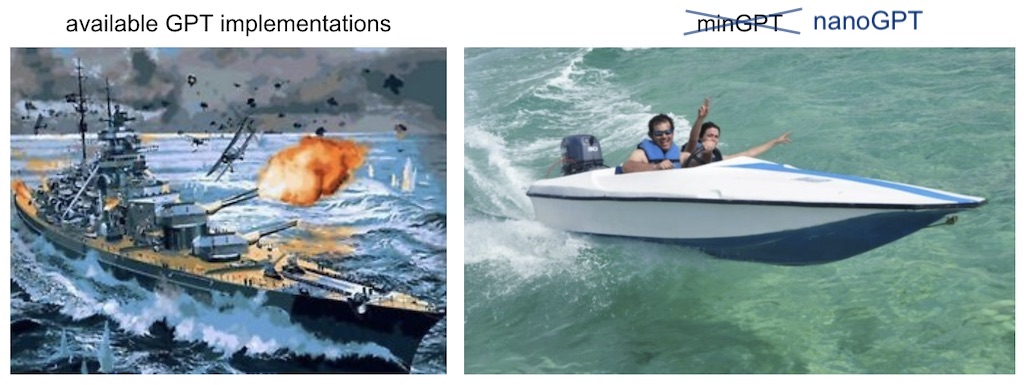

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/DL-NLP/
!pip install torch numpy transformers datasets tiktoken wandb tqdm
!git clone https://github.com/karpathy/nanoGPT.git
%cd nanoGPT
!ldconfig /usr/lib64-nvidia


/content/drive/MyDrive/DL-NLP
fatal: destination path 'nanoGPT' already exists and is not an empty directory.
/content/drive/MyDrive/DL-NLP/nanoGPT
/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link



In [6]:
!python data/shakespeare_char/prepare.py
!python train.py config/train_shakespeare_char.py
!python sample.py --out_dir=out-shakespeare-char

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens
Overriding config with config/train_shakespeare_char.py:
# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-shakespeare-char'
eval_interval = 250 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run_name = 'mini-gpt'

dataset = 'shakespeare_char'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3 # with baby netwo

### Traduction à base de modèle Seq-to-Seq

Dans ce lab, nous allons enseigner à un réseau neuronal à traduire du français vers l'anglais. Nous écrirons nos propres classes et fonctions pour prétraiter les données afin d'effectuer nos tâches de modélisation NLP.


```sh
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```
... avec des degrés de succès variables.

Cela est rendu possible par l'idée simple mais puissante du réseau de séquence à séquence, dans lequel deux réseaux neuronaux récurrents travaillent ensemble pour transformer une séquence en une autre. Un réseau encodeur condense une séquence d'entrée en un vecteur, et un réseau décodeur déplie ce vecteur en une nouvelle séquence.

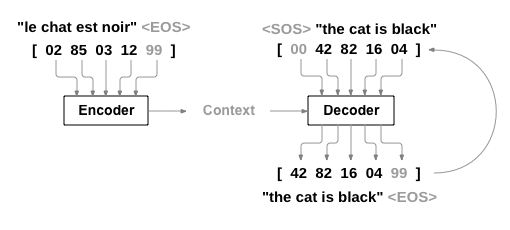

Pour améliorer ce modèle, il est possible d'utiliser un mécanisme d'attention, qui permet au décodeur d'apprendre à se concentrer sur une plage spécifique de la séquence d'entrée.

In [4]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
# Télécharger les données du tutoriel
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2024-02-24 11:16:25--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.164.154.30, 18.164.154.123, 18.164.154.17, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.164.154.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  16.5MB/s    in 0.2s    

2024-02-24 11:16:25 (16.5 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Chargement et préparation des données

In [6]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))



## Le Modèle Seq2Seq

Un Réseau de Neurones Récurrent, ou RNN, est un réseau qui opère sur une séquence et utilise sa propre sortie comme entrée pour les étapes suivantes.

Un réseau de Séquence à Séquence, ou réseau seq2seq, ou réseau Encodeur-Décodeur, est un modèle composé de deux RNN appelés l'encodeur et le décodeur. L'encodeur lit une séquence d'entrée et produit un vecteur unique, et le décodeur lit ce vecteur pour produire une séquence de sortie.

Considérons la phrase "Je ne suis pas le chat noir" → "I am not the black cat". La plupart des mots dans la phrase d'entrée ont une traduction directe dans la phrase de sortie, mais sont dans un ordre légèrement différent, par exemple "chat noir" et "black cat". En raison de la construction "ne/pas", il y a également un mot de plus dans la phrase d'entrée. Il serait difficile de produire une traduction correcte directement à partir de la séquence des mots d'entrée.

Avec un modèle seq2seq, l'encodeur crée un seul vecteur qui, dans le cas idéal, encode le "sens" de la séquence d'entrée dans un seul vecteur - un seul point dans un espace N dimensionnel de phrases.



### L'encodeur

L'encodeur d'un réseau seq2seq est un RNN qui produit une valeur pour chaque mot de la phrase d'entrée. Pour chaque mot d'entrée, l'encodeur produit un vecteur et un état caché, et utilise l'état caché pour le mot d'entrée suivant.

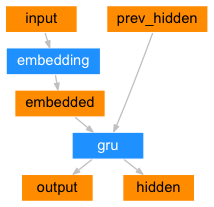





In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### Le décodeur

Le décodeur est un autre RNN qui prend en entrée le(s) vecteur(s) de sortie de l'encodeur et produit une séquence de mots pour créer la traduction.

À chaque étape de décodage, le décodeur reçoit un jeton d'entrée et un état caché. Le jeton d'entrée initial est le jeton de début de chaîne `<SOS>` (start-of-string), et le premier état caché est le vecteur contextuel (le dernier état caché de l'encodeur).

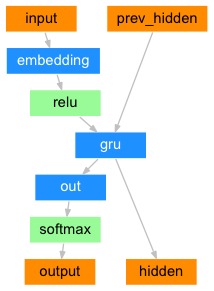





In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.





## Entrainement

### Préparation des données d'entrainement

Pour l'entraînement, pour chaque paire, nous aurons besoin d'un tenseur d'entrée (indices des mots dans la phrase d'entrée) et d'un tenseur cible (indices des mots dans la phrase cible). Lors de la création de ces vecteurs, nous ajouterons le jeton EOS à chaque séquence.




In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

### Entraînement du modèle

Pour l'entraînement, nous faisons passer la phrase d'entrée à travers l'encodeur et gardons une trace de chaque sortie ainsi que du dernier état caché. Ensuite, le décodeur reçoit le jeton <SOS> comme première entrée, et le dernier état caché de l'encodeur comme premier état caché


In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Évaluation

L'évaluation est principalement similaire à l'entraînement, mais il n'y a pas de cibles, donc nous alimentons simplement les prédictions du décodeur en retour pour chaque étape. À chaque fois qu'il prédit un mot, nous l'ajoutons à la chaîne de sortie, et s'il prédit le jeton EOS, nous nous arrêtons là.



In [18]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

Nous pouvons évaluer des phrases aléatoires du jeu d'entraînement et imprimer l'entrée, la cible et la sortie pour émettre des jugements de qualité subjectifs :




In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Entraînement et évaluation

Nous pouvons effectivement initialiser un réseau et commencer l'entraînement. N'oubliez pas que les phrases d'entrée ont été fortement filtrées. Pour ce petit ensemble de données, nous pouvons utiliser des réseaux relativement petits avec 256 nœuds cachés et une seule couche GRU.




In [20]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 21s (- 5m 18s) (5 6%) 1.7060
0m 39s (- 4m 36s) (10 12%) 0.9016
0m 57s (- 4m 11s) (15 18%) 0.5707
1m 15s (- 3m 47s) (20 25%) 0.3799
1m 34s (- 3m 28s) (25 31%) 0.2631
1m 52s (- 3m 7s) (30 37%) 0.1882
2m 11s (- 2m 48s) (35 43%) 0.1405
2m 29s (- 2m 29s) (40 50%) 0.1074
2m 47s (- 2m 10s) (45 56%) 0.0860
3m 6s (- 1m 51s) (50 62%) 0.0708
3m 24s (- 1m 32s) (55 68%) 0.0607
3m 42s (- 1m 14s) (60 75%) 0.0532
4m 0s (- 0m 55s) (65 81%) 0.0478
4m 19s (- 0m 37s) (70 87%) 0.0435
4m 37s (- 0m 18s) (75 93%) 0.0408
4m 55s (- 0m 0s) (80 100%) 0.0378


In [21]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> je suis encore occupee
= i m still busy
< i m still busy right now <EOS>

> elle est dans une bonne passe
= she s on a roll
< she s on a new house in the same boat

> il est paresseux
= he s lazy
< he is absorbed in reading detective novels <EOS>

> je meurs de soif
= i m dying of thirst
< i m dying for the right away <EOS>

> tu es un de ces menteurs !
= you are such a liar !
< you are such a jerk <EOS>

> tu es fantasque
= you re temperamental
< you re imagining things <EOS>

> je suis content de vous revoir
= i m glad to see you back
< i m glad to see you in your advice <EOS>

> elles mentent toutes
= they re all lying
< they re all their time <EOS>

> tu es tres habile
= you re very clever
< you re very productive today <EOS>

> il se planque
= he s gone into hiding
< he is fighting with his nowhere <EOS>

